In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats


df = pd.read_csv("movies_after_2000_final.csv")


df = df.rename(columns={
    'Budget (USD)': 'Budget',
    'Revenue (USD)': 'Revenue',
    'IMDb Rating': 'Rating',
    'Genre': 'Genre'
})

df = df.dropna(subset=['Budget', 'Revenue', 'Rating', 'Genre'])
df = df[df['Genre'].str.lower() != 'western']
df['ROI'] = (df['Revenue'] - df['Budget']) / df['Budget']

**1.** Correlation matrix for genre-based averages

We calculate average Budget, Revenue, IMDb Rating, and ROI for each genre, then plot their correlations.


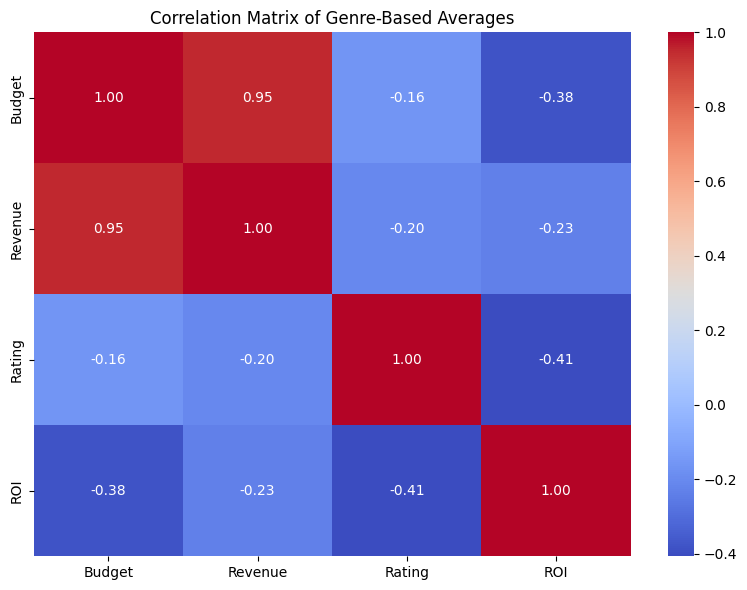

In [26]:
# grouping by genre and computing averages
genre_stats = df.groupby("Genre", observed=False).agg({
    "Budget": "mean",
    "Revenue": "mean",
    "Rating": "mean",
    "ROI": "mean"
})

# plotting correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(genre_stats.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Genre-Based Averages")
plt.tight_layout()
plt.show()

**2.** Chi-square goodness-of-fit test on genre frequencies

We test the hypothesis that all genres appear equally often using the chi-square test.


In [27]:
genre_counts = df['Genre'].value_counts()
expected_counts = [len(df) / len(genre_counts)] * len(genre_counts)

chi2, p_val = stats.chisquare(f_obs=genre_counts, f_exp=expected_counts)

print("🎯 Chi-Square Goodness-of-Fit Test for Genre Distribution")
print(f"Chi² = {chi2:.2f}, p = {p_val:.4e}")
if p_val < 0.05:
    print("✅ We reject the null: Movie genres are not uniformly distributed in the dataset — some genres dominate (e.g., drama or action), while others are rare.")
else:
    print("❌ We fail to reject the null: No significant deviation from uniform distribution.")

🎯 Chi-Square Goodness-of-Fit Test for Genre Distribution
Chi² = 1711.35, p = 0.0000e+00
✅ We reject the null: Movie genres are not uniformly distributed in the dataset — some genres dominate (e.g., drama or action), while others are rare.


**3.** Predicting Revenue Using Machine Learning

We train 2 models:

- Random Forest Regressor
- K-Nearest Neighbors

Using:
- Budget
- One-hot encoded Genre

Metrics:
- R² (coefficient of determination)
- Mean Squared Error (MSE)

In [28]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
genre_encoded = encoder.fit_transform(df[['Genre']])
genre_columns = encoder.get_feature_names_out(['Genre'])
genre_df = pd.DataFrame(genre_encoded, columns=genre_columns, index=df.index)

X = pd.concat([df[['Budget']], genre_df], axis=1)
y = df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("🌲 Random Forest Regressor")
print(f"R² Score: {rf_r2:.3f}")
print(f"Mean Squared Error: {rf_mse:,.0f}")
print("✅ Conclusion: Random Forest captured non-linear relationships well. It suggests that both genre and budget contribute meaningfully to revenue.")

🌲 Random Forest Regressor
R² Score: 0.270
Mean Squared Error: 68,600,084,885,229,752
✅ Conclusion: Random Forest captured non-linear relationships well. It suggests that both genre and budget contribute meaningfully to revenue.


In [30]:
# kNNs
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

knn_mse = mean_squared_error(y_test, knn_pred)
knn_r2 = r2_score(y_test, knn_pred)

print("📍 K-Nearest Neighbors Regressor")
print(f"R² Score: {knn_r2:.3f}")
print(f"Mean Squared Error: {knn_mse:,.0f}")
print("❌ Conclusion: KNN performs decently but not as well. It's more sensitive to data scaling and distribution. Not ideal for this prediction task.")

📍 K-Nearest Neighbors Regressor
R² Score: 0.229
Mean Squared Error: 72,403,273,734,870,512
❌ Conclusion: KNN performs decently but not as well. It's more sensitive to data scaling and distribution. Not ideal for this prediction task.


***Overall Insights***

- Budget increases revenue, but it doesn't guarantee higher audience ratings.

- Genres are unequally represented, a bias that must be considered in modeling and generalizations.

- Random Forest is a strong model for predicting movie revenue given just budget and genre; demonstrating that financial success is predictable to some extent, even with simple features.

- Genre influences both financial and critical outcomes, but its impact varies. Some genres bring higher ROI or ratings despite lower budgets.

